IMPORT LIBRARIES



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


DATASET

In [2]:
df = pd.read_csv("sales.csv", encoding='latin1')
df.head()


,OrderID,OrderDate,CustomerID,CustomerName,Product,Category,Quantity,UnitPrice
0,1001,2024-01-05,501,Amit Shah,Laptop,Electronics,1,55000
1,1002,2024-01-06,502,Priya Verma,Headphones,Electronics,2,1500
2,1003,2024-01-06,501,Amit Shah,Laptop,Electronics,1,55000
3,1004,2024-01-07,503,Rohit Kumar,Mobile,Electronics,1,22000
4,1005,2024-01-07,504,Sneha Rao,Shoes,Fashion,3,900


DATA CLEANING

In [4]:
# remove duplicates
df.drop_duplicates(inplace=True)

# check missing values
df.isnull().sum()

# fill missing values or drop
df.dropna(inplace=True)

# convert date column
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# convert other numeric columns
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')

# calculate revenue
df['Revenue'] = df['Quantity'] * df['UnitPrice']

df.head()

,OrderID,OrderDate,CustomerID,CustomerName,Product,Category,Quantity,UnitPrice,Revenue
0,1001,2024-01-05,501,Amit Shah,Laptop,Electronics,1,55000,55000
1,1002,2024-01-06,502,Priya Verma,Headphones,Electronics,2,1500,3000
2,1003,2024-01-06,501,Amit Shah,Laptop,Electronics,1,55000,55000
3,1004,2024-01-07,503,Rohit Kumar,Mobile,Electronics,1,22000,22000
4,1005,2024-01-07,504,Sneha Rao,Shoes,Fashion,3,900,2700


BASIC EDA(SALES TREND)

/usr/local/lib/python3.12/dist-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


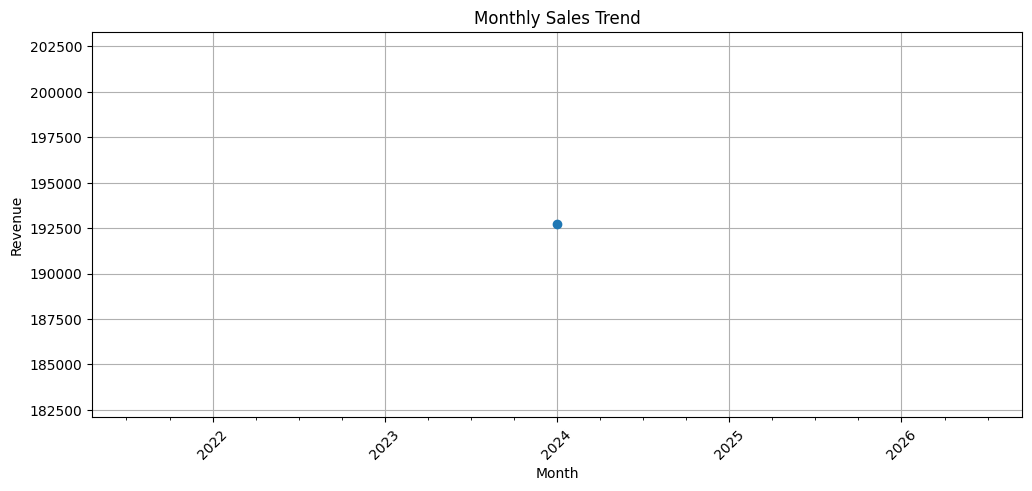

In [6]:
df['Month'] = df['OrderDate'].dt.to_period('M')

monthly_sales = df.groupby('Month')['Revenue'].sum()

plt.figure(figsize=(12,5))
monthly_sales.plot(marker='o')
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.grid()
plt.show()


TOP SELLING PRODUCTS

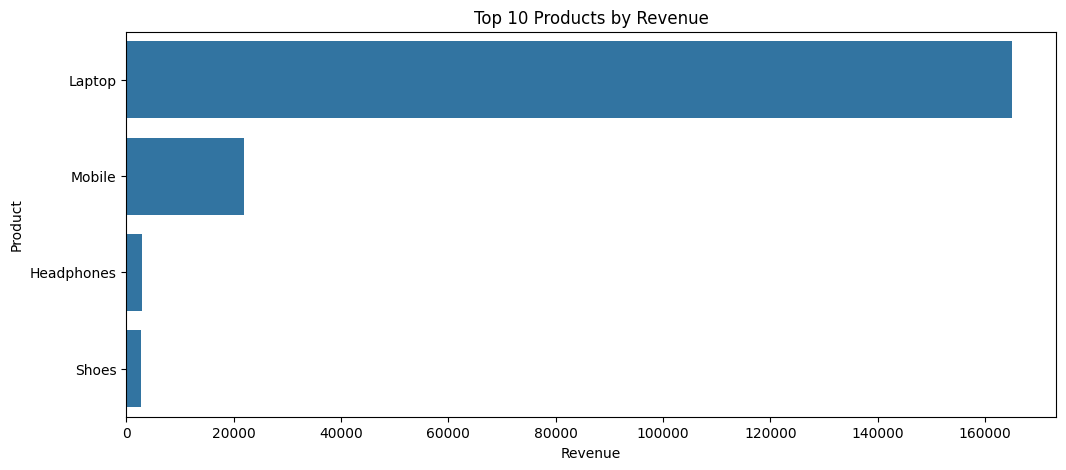

In [9]:
top_products = df.groupby('Product')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.ylabel("Product")
plt.show()

REGION WISE SALES

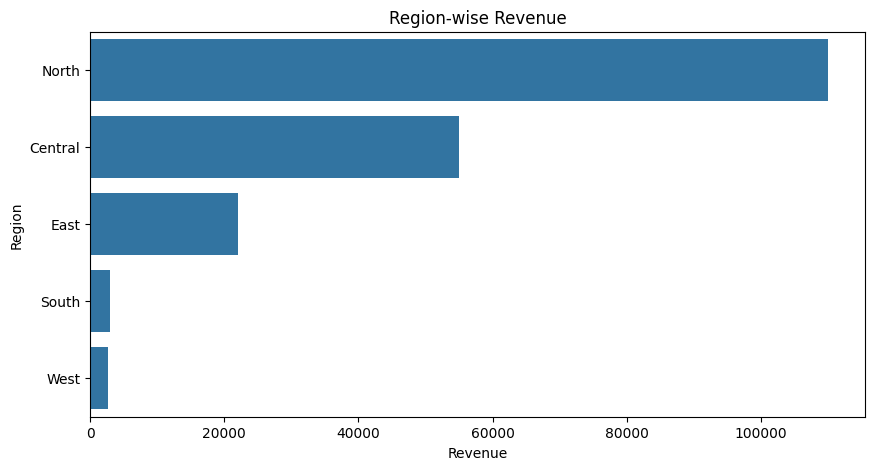

In [17]:
region_sales = df.groupby('Region')['Revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=region_sales.values, y=region_sales.index)
plt.title("Region-wise Revenue")
plt.xlabel("Revenue")
plt.ylabel("Region")
plt.show()

### Add a 'Region' column to the DataFrame

Since your original data does not contain a 'Region' column, we will add a new one. For demonstration purposes, I will assign some sample regions. You should replace this logic with your actual region data, which might involve:

1.  **Mapping based on existing columns**: If you have a way to determine regions from `CustomerID`, `CustomerName`, or other columns.
2.  **Merging with an external dataset**: If you have a separate file (e.g., CSV, Excel) that contains customer IDs and their corresponding regions.
3.  **Manual assignment**: If the number of unique customers/products is small enough to assign regions manually.

In [16]:
# Example: Add a 'Region' column based on CustomerID for demonstration
# In a real scenario, you would have actual region data or a mapping.

# Create a mapping from CustomerID to a sample Region
# This is just an example; you'll need to define your own logic
region_mapping = {
    501: 'North',
    502: 'South',
    503: 'East',
    504: 'West',
    505: 'Central' # Assuming there might be more CustomerIDs
}

# Apply the mapping to create the 'Region' column
df['Region'] = df['CustomerID'].map(region_mapping)

# If some CustomerIDs don't have a mapping, you might want to fill them
# For example, fill with 'Unknown' or a default region
df['Region'] = df['Region'].fillna('Unknown')

# Display the DataFrame with the new 'Region' column
display(df.head())

,OrderID,OrderDate,CustomerID,CustomerName,Product,Category,Quantity,UnitPrice,Revenue,Month,Region
0,1001,2024-01-05,501,Amit Shah,Laptop,Electronics,1,55000,55000,2024-01,North
1,1002,2024-01-06,502,Priya Verma,Headphones,Electronics,2,1500,3000,2024-01,South
2,1003,2024-01-06,501,Amit Shah,Laptop,Electronics,1,55000,55000,2024-01,North
3,1004,2024-01-07,503,Rohit Kumar,Mobile,Electronics,1,22000,22000,2024-01,East
4,1005,2024-01-07,504,Sneha Rao,Shoes,Fashion,3,900,2700,2024-01,West


CUSTOMER SEGMENTATION(RFM ANALYSIS)

In [18]:
today = df['OrderDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'OrderDate': lambda x: (today - x.max()).days,
    'OrderID': 'count',
    'Revenue': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
501,3,2,110000
502,3,1,3000
503,2,1,22000
504,2,1,2700
505,1,1,55000


ASSIGN RFM SCORES

In [21]:
# Function to safely apply qcut and assign scores
def assign_rfm_score(series, num_quantiles, ascending=True):
    # Determine the actual number of bins pd.qcut can create
    try:
        _, bins = pd.qcut(series, q=num_quantiles, retbins=True, duplicates='drop')
        actual_num_bins = len(bins) - 1
    except ValueError:
        # If qcut fails to create any bins (e.g., all values are identical),
        # assign a default score.
        actual_num_bins = 1 # Treat as one bin for scoring purposes

    if actual_num_bins == 0:
        # This case implies all values are identical or series is empty after duplicates='drop'
        # Assign a single score (e.g., mid-score or 1)
        return pd.Series(num_quantiles // 2 + 1 if ascending else num_quantiles // 2, index=series.index)

    # Adjust labels based on actual_num_bins
    if ascending:
        labels = list(range(1, actual_num_bins + 1))
    else: # Recency is reverse scored
        labels = list(range(actual_num_bins, 0, -1))

    return pd.qcut(series, q=num_quantiles, labels=labels, duplicates='drop')

# Apply to rfm DataFrame
rfm['R_score'] = assign_rfm_score(rfm['Recency'], 4, ascending=False)
rfm['F_score'] = assign_rfm_score(rfm['Frequency'], 4, ascending=True)
rfm['M_score'] = assign_rfm_score(rfm['Monetary'], 4, ascending=True)

rfm['RFM_Score'] = rfm['R_score'].astype(int) + rfm['F_score'].astype(int) + rfm['M_score'].astype(int)
rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerID,,,,,,,
501,3,2,110000,1,1,4,6
502,3,1,3000,1,1,1,3
503,2,1,22000,2,1,2,5
504,2,1,2700,2,1,1,4
505,1,1,55000,2,1,3,6


SEGMENT CUSTOMER

In [22]:
def segment(rfm_score):
    if rfm_score >= 9:
        return "VIP Customers"
    elif rfm_score >= 7:
        return "Loyal Customers"
    elif rfm_score >= 5:
        return "Potential Customers"
    elif rfm_score >= 3:
        return "At-Risk"
    else:
        return "Lost"

rfm['Segment'] = rfm['RFM_Score'].apply(segment)
rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,
501,3,2,110000,1,1,4,6,Potential Customers
502,3,1,3000,1,1,1,3,At-Risk
503,2,1,22000,2,1,2,5,Potential Customers
504,2,1,2700,2,1,1,4,At-Risk
505,1,1,55000,2,1,3,6,Potential Customers


PLOT CUSTOMER SEGMENT

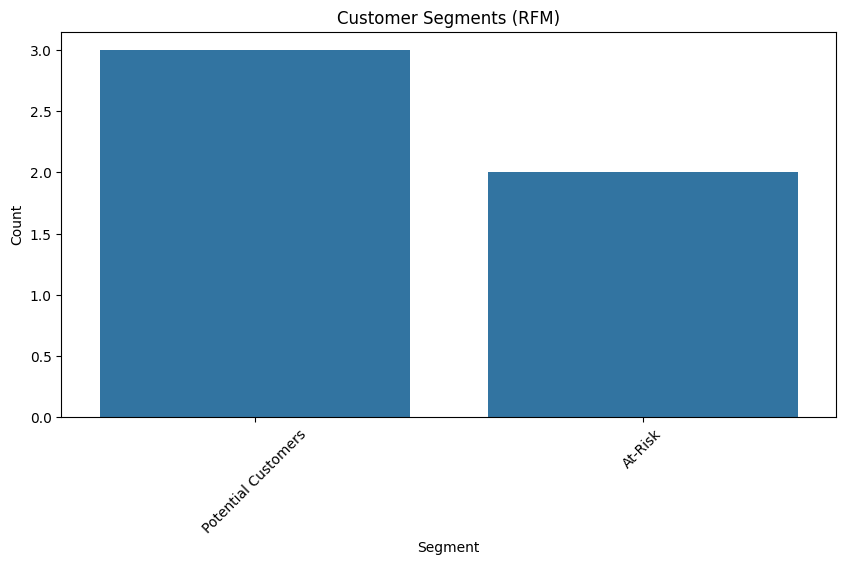

In [23]:
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title("Customer Segments (RFM)")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


AUTOMATION- WEEKLY REPORT EXPORT

In [25]:
weekly_report = df.resample('W', on='OrderDate')['Revenue'].sum()

report = pd.DataFrame({
    'Week': weekly_report.index,
    'Revenue': weekly_report.values
})

report.to_excel("Weekly_Sales_Report.xlsx", index=False)

print("Weekly report generated successfully!")


Weekly report generated successfully!
